# Add `prior_` features

`prior_` feature는 어떤 `user`가 처음부터 현재 문제를 풀기 전까지 전 기간동안 어떤 경험을 쌓았는지 나타내는 feature이다. 

예를들어, 현재 풀려는 문제의 `KnowledgeTag`가 3일 때, 여태까지 `KnowledgeTag`가 3인 문제를 몇 번이나 풀었는가? 와 같은 것이 `prior_` feature의 예이다. 

In [2]:
import os, sys
from pathlib import Path
from glob import glob

In [3]:
BASE_PATH = Path('.').resolve().parent
BASE_PATH

PosixPath('/opt/ml')

In [4]:
if BASE_PATH.as_posix() not in sys.path:
    sys.path.append(BASE_PATH.as_posix())

In [5]:
sys.path

['/opt/ml/jaepil',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/transformers-4.6.1-py3.8.egg',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/opt/ml/.ipython',
 '/opt/ml']

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import numpy as np
import pandas as pd

In [8]:
import numba
import dask.dataframe as dd

In [9]:
import json
import pickle

In [10]:
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from time import time

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.6.0'

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # Always check cudatoolkit version!

device(type='cuda', index=0)

In [13]:
from collections import defaultdict

## Load data

`['user_id', 'Timestamp']`로 sorting되고

`Timestamp`가 `datetime64` type으로 변환되었으며

`testId`에서 대분류인 `test_cat`을 뽑아내고

`assessmentItemID`에서 문제번호인 `question_num`을 뽑아낸

상태로 저장된 `train_df` 피클을 불러온다. 

In [80]:
train_df = pd.read_pickle('train_df.pkl')

### `prior` feature

`prior`은 어떤 사람이 한 문제를 푸는 시점 이전 전체의 기록이 어떤지를 본다. (굳이 한 test 내일 필요 없음)

즉, 어떤 문제를 풀기 전 모든 기간동안 어떤 `KnowledgeTag`를 몇 번이나 풀었는지... 그 정답률은 어땠는지... 등을 보는 것이다. 

#### `prior_KnowledgeTag_frequency` 

이전에 어떤 Knowledge Tag를 몇 번이나 봤는지 누적빈도를 구한다. 

In [81]:
train_df['prior_KnowledgeTag_frequency'] = train_df.groupby(['userID', 'KnowledgeTag']).cumcount()

`prior_KnowledgeTag_accuracy`는 shift가 이상하게 되는 문제가 있다. 값이 np.inf가 되거나 1을 넘어가거나 하는 일이 생긴다. 

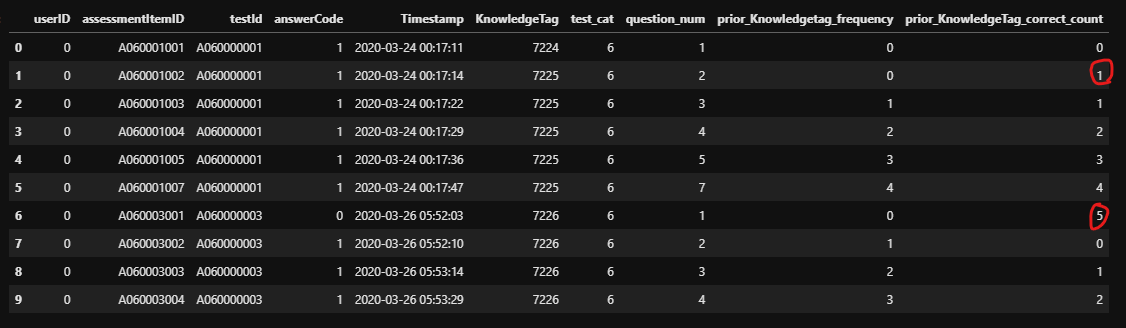

In [82]:
# train_df['prior_KnowledgeTag_correct_count'] = train_df.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumsum().shift(fill_value=0)
# train_df['prior_KnowledgeTag_accuracy'] = (train_df.prior_KnowledgeTag_correct_count / train_df.prior_KnowledgeTag_frequency).fillna(0)

# train_df.prior_KnowledgeTag_accuracy = train_df.prior_KnowledgeTag_accuracy.replace([-np.inf, np.inf], 0)